### 1. Reading datasets

##### 1.1 Read the data

- Imports `pandas`, `string`, and `nltk.tokenize` for data reading, handling punctuation removal, and text tokenization.

- Reads a dataset of 30,000 hotel reviews from a JSON file using pandas.

- Defines `tokenize_no_punctuation` function:
    -  To remove punctuation and tokenize text.

- Extracts "overall" ratings from the "ratings" column, creating a new "overall" column.

- Applies text preprocessing to the "text" column, removing punctuation and tokenizing the text, storing the results in a new column.

- Splits the dataset into training (first 10,000 entries), development (next 10,000 entries), and testing (remaining entries) segments for model development.


In [12]:
import pandas as pd
import string
from nltk.tokenize import word_tokenize

data =  pd.read_json("random_30000_hotel_reviews.JSON",lines=True)

def tokenize_no_punctuation (text):
    text = text.translate(text.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    return tokens


# Pulling the "overall rating" from the rating column and named "overall"
data["overall"] = [data["ratings"][i]["overall"] for i in range(len(data))]

# Perform the punctuation remerval and tokenisation for the "text" column
data["tokenize_no_punctuation"] = [tokenize_no_punctuation(i) for i in data["text"]]

# Split data into training, development and testing
training_data = data[:10000]
development_data = data[10000:20000]
testing_data = data[20000:]

##### 1.2 Transforming data for part 2

It is expected that the text contains stopwords and is in various tenses or in upper case. To enhance data visualization for part 2, the text is cleaned by converting to lowercase, removing stopwords and punctuation, and applying lemmatization, utilizing NLTK and spaCy.

- Uses NLTK for `stopwords`, `string` and spaCy's `en_core_web_sm` for NLP tasks.

- Defines `clean_text` function to:
  - Lowers case, 
  - Removes punctuation.
  - Filters out stop words 
  - Lemmatizes remaining tokens using spaCy.


- Processes the "text" column in `development_data`, storing results in a new "clean_text" column.


In [13]:
from nltk.corpus import stopwords
import en_core_web_sm

nlp = en_core_web_sm.load()

def clean_text(text):
    text = text.lower()
    text = text.translate(text.maketrans('', '', string.punctuation))

    tokens = word_tokenize(text)
    stop_words = stopwords.words("english") 
    filtered_words = [word for word in tokens if word.lower() not in stop_words]

    text = " ".join(filtered_words)
    doc = nlp(text)
    lemmatized_tokens =  [token.lemma_ for token in doc]

    return lemmatized_tokens

development_data["clean_text"] = [clean_text(i) for i in development_data["text"]]

The first 5 rows of development data.

In [3]:
development_data.head()

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,overall,tokenize_no_punctuation,clean_text
10000,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Nice hotel - great location”,This was a nice hotel for the price I got at t...,"{'username': 'metalchicRichmond', 'num_cities'...",July 2011,84107,0,2012-05-04,129367971,False,4.0,"[This, was, a, nice, hotel, for, the, price, I...","[nice, hotel, price, get, last, minute, expedi..."
10001,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Perfect location and the room was generous in...,I stayed in this hotel in December of 2010 and...,"{'username': 'Noelle20', 'num_reviews': 1, 'id...",February 2011,93464,0,2011-02-15,96767715,False,4.0,"[I, stayed, in, this, hotel, in, December, of,...","[stay, hotel, december, 2010, february, travel..."
10002,"{'service': 1.0, 'cleanliness': 4.0, 'overall'...","“Rude staff, extra charges, overall unimpressive”",We traveled here with a big group for a weddin...,"{'username': 'amanduhcorazon', 'num_cities': 4...",September 2011,109008,3,2011-09-23,118469580,False,2.0,"[We, traveled, here, with, a, big, group, for,...","[travel, big, group, wedding, weekend, 16th, i..."
10003,"{'service': 4.0, 'cleanliness': 4.0, 'overall'...","“Great location, would stay here again”",Stayed here for 3 nights. Our room was a large...,"{'username': 'Peter G', 'num_cities': 6, 'num_...",November 2011,223019,2,2011-11-14,120569971,False,4.0,"[Stayed, here, for, 3, nights, Our, room, was,...","[stay, 3, night, room, large, room, 12th, floo..."
10004,"{'service': 3.0, 'cleanliness': 4.0, 'overall'...",“Disappointed in Chicago”,I stayed at the Allerton Hotel on the night of...,"{'username': 'redinked', 'num_cities': 12, 'nu...",August 2012,90973,1,2012-08-16,137342764,False,3.0,"[I, stayed, at, the, Allerton, Hotel, on, the,...","[stay, allerton, hotel, night, august, 8, live..."


### 2. Exploratory Data Analysis (EDA)


- `seaborn` and `matplotlib.pyplot` for creating graphs, visualize data distributions and trends

- `FreqDist` from NLTK to compute word frequency distributions.

- `ngrams` from NLTK for generating n-length sequences of text.


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.probability import FreqDist
from nltk import ngrams
import nltk

##### 2.1 The distribution of overall rating for development data

Graph description:
- The distribution of overall ratings imbalanced.
- The counts for ratings of 1.0 and 2.0 are the lowest among the ratings.
- The majority of the ratings are 5.0, with 4.0 being the second most common, suggesting a trend towards higher ratings in this dataset.

Impact for preprocessing:
- Due to the imbalance, techniques such as **oversampling** is needed to balance the distribution before modeling.

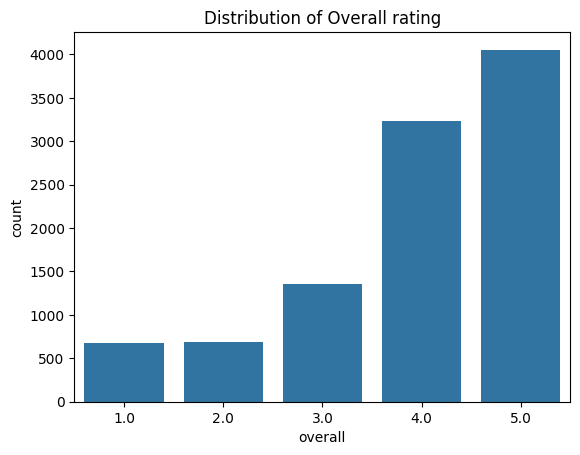

In [5]:
# Display distribution of overll rating in development_data
sns.countplot(x='overall', data=development_data)
plt.title('Distribution of Overall rating')
plt.show()

##### 2.2 The length distribution of comments

Defines a function `rating_length`:
-  That visualizes the distribution of comment lengths for a specified rating (`x`) within the `development_data` dataset.

- Filters `development_data` to include only entries matching the specified rating (`x`) and calculates the length of comments post-tokenization (excluding punctuation) in the `tokenize_no_punctuation` column.

- Utilizes `seaborn` to generate a histogram with Kernel Density Estimate (KDE) overlay, showing the distribution of comment lengths for the given rating.



Graph description:
- The histogram shows that most comments have lengths under 250 words.
- There is trend where positive comments (ratings of 4.0 and 5.0) are generally shorter in length.
- Customers might tend to write more when they are leaving negative comments, as indicated by the longer average comment lengths for ratings of 1.0 and 2.0.



The average length of ratings:
- The average length of rating 1.0 is: 195
- The average length of rating 2.0 is: 199
- The average length of rating 3.0 is: 176
- The average length of rating 4.0 is: 148
- The average length of rating 5.0 is: 133

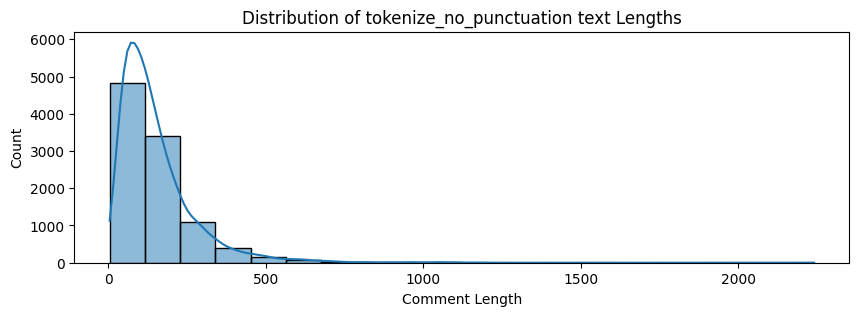

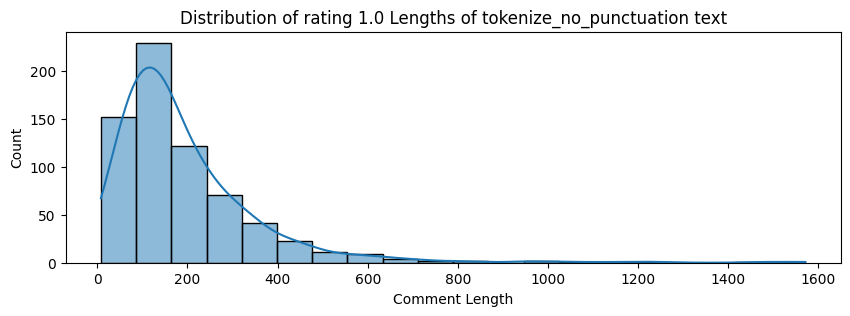

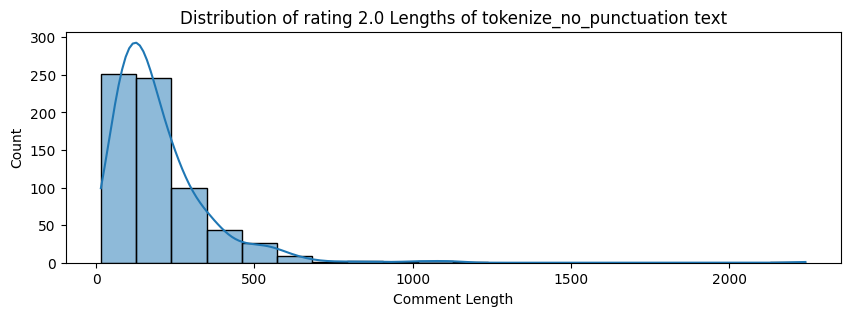

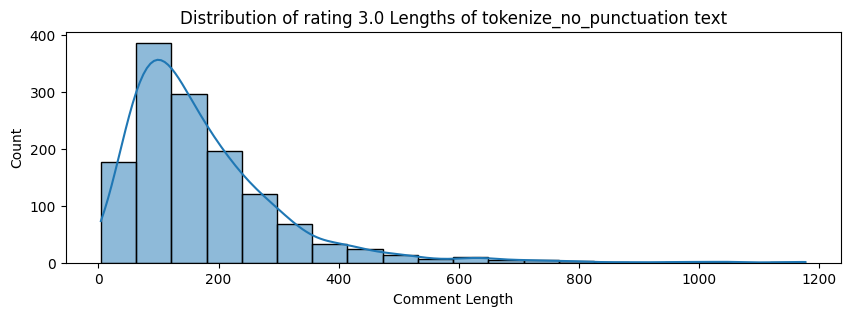

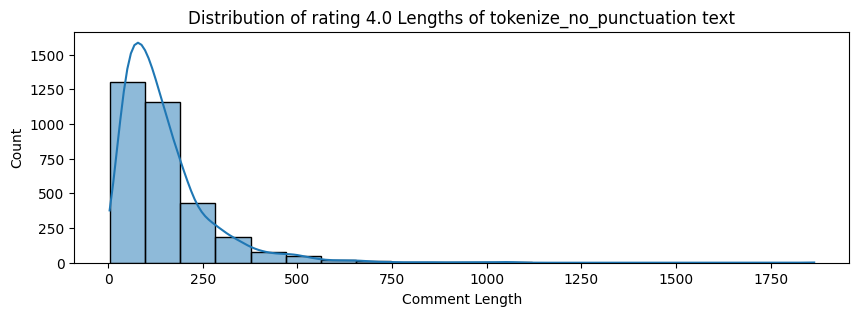

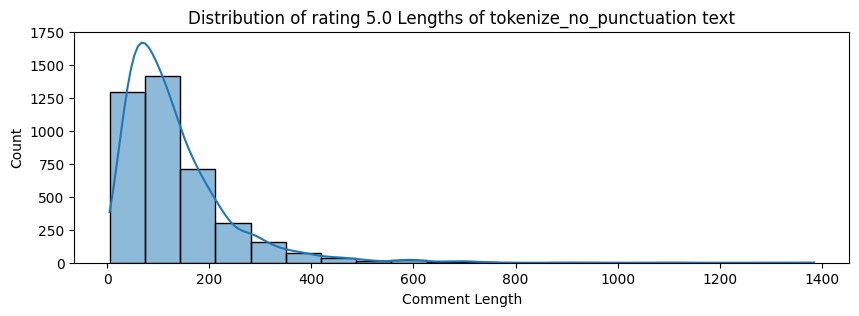

The average length of rating 1.0 is: 195
The average length of rating 2.0 is: 199
The average length of rating 3.0 is: 176
The average length of rating 4.0 is: 148
The average length of rating 5.0 is: 133


In [6]:
length = development_data['tokenize_no_punctuation'].apply(lambda x: len(x))
plt.figure(figsize=(10, 3)) 
sns.histplot(length, bins=20, kde=True)
plt.title('Distribution of tokenize_no_punctuation text Lengths')
plt.xlabel('Comment Length')
plt.show()

def rating_length(x):
    plt.figure(figsize=(10, 3)) 
    length =development_data[development_data['overall']==x]['tokenize_no_punctuation'].apply(lambda x: len(x))
    sns.histplot(length, bins=20, kde=True)
    plt.title(f'Distribution of rating {i}.0 Lengths of tokenize_no_punctuation text')
    plt.xlabel('Comment Length')
    plt.show()
    return round(sum(length)/len(length))

average_length = []
for i in range(1,6):
    average_length.append(rating_length(i))


for n, e in enumerate(average_length):
    print(f"The average length of rating {n+1}.0 is: {e}")

##### 2.3 The words frequencies of comments

Graph description:
- The graph suggests a high occurrence of typical stopwords within the tokenize_no_punctuation column, with words like "the", "a", and "and" potentially being common.

Impact for preprocessing:
- Given the potential prevalence of stopwords, applying **stopwords removal**, **lowercasing** and **lemmatization** to the data could enhance the dataset by focusing on more meaningful words.

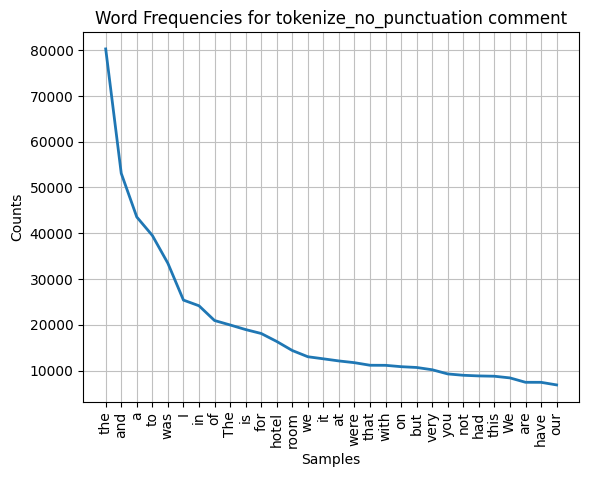

<Axes: title={'center': 'Word Frequencies for tokenize_no_punctuation comment'}, xlabel='Samples', ylabel='Counts'>

In [7]:
tokenize_no_punctuation = development_data["tokenize_no_punctuation"]
fdist = FreqDist([ii for i in tokenize_no_punctuation for ii in i])
plt.title(f'Word Frequencies for tokenize_no_punctuation comment')
fdist.plot(30, cumulative=False)

Graph description:
- For clarity in the chart's output, ratings of 5.0 and 4.0 were categorized as "Positive", while ratings of 2.0 and 1.0 were labeled as "Negative".
- Following the removal of stopwords and punctuation, along with lemmatization and lower case, the words "hotel", "room", and "stay" emerged as the most frequent terms within both "Positive" and "Negative" categories. This indicates that these reviews are closely related to the core hotel experience.


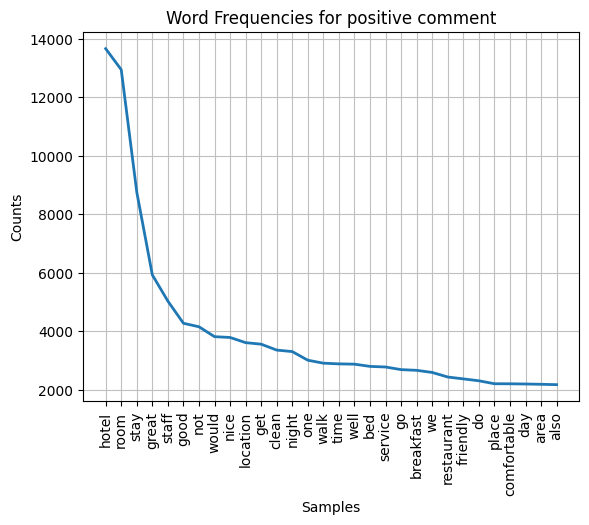

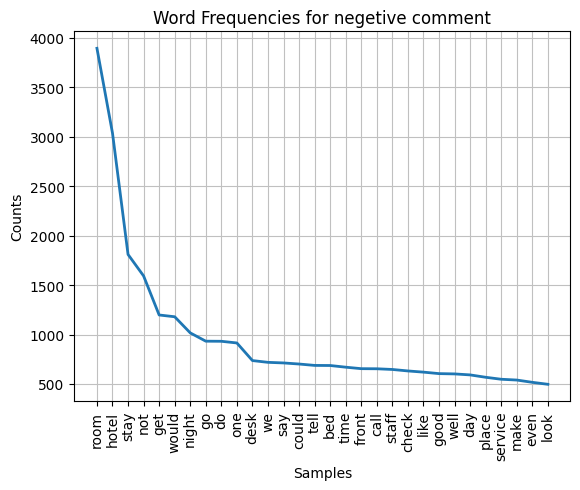

<Axes: title={'center': 'Word Frequencies for negetive comment'}, xlabel='Samples', ylabel='Counts'>

In [8]:
positive = development_data[development_data["overall"].isin([5.0, 4.0])]['clean_text']
fdist = FreqDist([ii for i in positive for ii in i])
plt.title(f'Word Frequencies for positive comment')
fdist.plot(30, cumulative=False)

negetive = development_data[development_data["overall"].isin([1.0, 2.0])]['clean_text']
fdist = FreqDist([ii for i in negetive for ii in i])
plt.title(f'Word Frequencies for negetive comment')
fdist.plot(30, cumulative=False)

Graph description:
- N-grams are sequences of 'n' consecutive words used to capture context in text analysis, providing insights into common phrases within a dataset. By analyzing n-grams, we can capture the context to a certain extent, which single words often miss.

- 3-grams were used to identify the most common sequences of three words in comments.

- In the positive comments, the 3-grams "within walking distance" "staff friendly helpful" and "front desk staff" were frequent. This suggests that proximity to destinations, helpful staff, and positive interactions at the front desk are aspects commonly associated with positive experiences.

- In the negative comments, the 3-grams "call front desk" "do not work" and "front desk staff" appeared often. These phrases indicate that issues requiring calls to the front desk, amenities not working properly, and potentially negative interactions with front desk staff are points of dissatisfaction for customers.

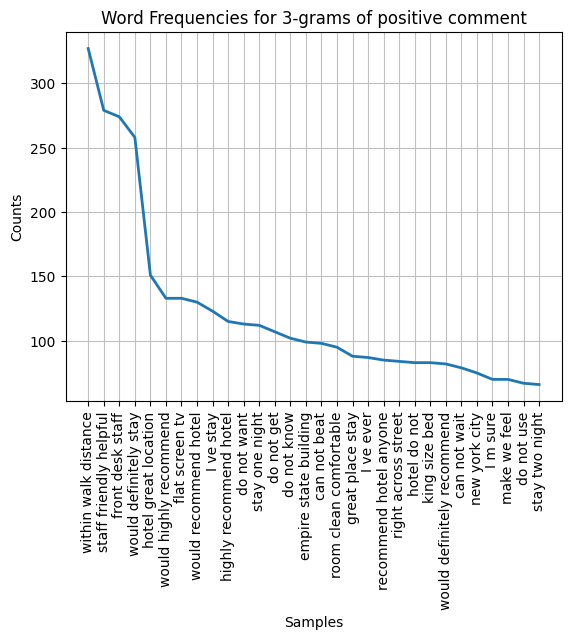

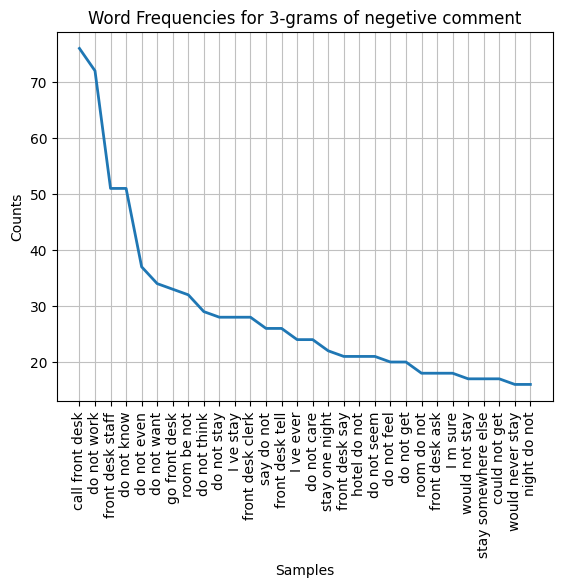

<Axes: title={'center': 'Word Frequencies for 3-grams of negetive comment'}, xlabel='Samples', ylabel='Counts'>

In [9]:
positive_text = " ".join([" ".join(i) for i in positive])
negetive_text = " ".join([" ".join(i) for i in negetive])
positive_tokens = nltk.word_tokenize(positive_text)
negetive_tokens = nltk.word_tokenize(negetive_text)

# Function to generate n-grams
def generate_ngrams(text, n):
    n_grams = ngrams(text, n)
    return [' '.join(gram) for gram in n_grams]

n_value = 3  

ngrams_list = generate_ngrams(positive_tokens, n_value)
fdist = FreqDist(ngrams_list)
plt.title(f'Word Frequencies for 3-grams of positive comment')
fdist.plot(30, cumulative=False)


ngrams_list = generate_ngrams(negetive_tokens, n_value)
fdist = FreqDist(ngrams_list)
plt.title(f'Word Frequencies for 3-grams of negetive comment')
fdist.plot(30, cumulative=False)

##### 2.4 Conclusion of the impact for preprocessing
- To address imbalances data, **oversampling** methods may be employed to equalize the distribution prior to modeling.
- **stopwords removal**, **lowercasing** and **lemmatization** from the dataset is advised to forcus more on more meaningful words.

### 3. Preprocessing

##### 3.1 Transforming data for part 4

- For part 4 of the experiment, these preprocessing steps create three new columns corresponding to each text transformation.

- **Stop-word Removal Function (`stop_word_removal`):**
  - Removes English stopwords and returns filtered tokens.

- **Lemmatization Function (`Lemmatize`):**
  - Transforms tokens into their base forms (lemmas).

- **Lowercasing Function (`lower_text`):**
  - Converts a list of tokens to lowercase.

- **Application to Data:**
  - Applies `stop_word_removal` to `tokenize_no_punctuation`, storing results in `no_stop_word_text`.
  - Applies `Lemmatize` to `no_stop_word_text`, storing lemmatized text in `lemmatize_text`.
  - Applies `lower_text` to `lemmatize_text`, storing the lowercased text in `lower_text`.




In [14]:
def stop_word_removal(token):
    # Remove stopwords and punctuation
    stop_words = stopwords.words("english") 
    tokens =  filtered_words = [word for word in token if word.lower() not in stop_words]
    return tokens

def Lemmatize(token):
    # Lemmatize the tokens
    text = " ".join(token)
    doc = nlp(text)
    tokens =  [token.lemma_ for token in doc]
    return tokens

def lower_text(text):
    # Lowercasing
    text = " ".join(text)
    text = text.lower()
    tokens = word_tokenize(text)
    return tokens

development_data["no_stop_word_text"] = [stop_word_removal(i) for i in development_data["tokenize_no_punctuation"]]
development_data["lemmatize_text"] = [Lemmatize(i) for i in development_data["no_stop_word_text"]]
development_data["lower_text"] = [lower_text(i) for i in development_data["lemmatize_text"]]

### 4. Selecting supervised method for sentiment classification

#### 4.1 Methodology

##### Medel selection

Multinomial Naive Bayes, Logistic Regression and Support Vector Machine was used in the experiment part. 

**Multinomial Naive Bayes (NB):**
- A probabilistic learning model based on the Bayes theorem, Multinomial NB is particularly suited for text classification with discrete features.
- Efficient with large datasets.
- Effective for discrete feature handling, like word counts.
- Simple yet surprisingly accurate for text classification.



**Logistic Regression:**
- Estimates the probabilities using a logistic function, which is particularly effective for sentiment classification by modeling the probability of classes based on feature vectors.
- Provides class probability estimates, revealing prediction strength.
- Handles binary and continuous data well, with robustness to noise.
- Offers regularization to avoid overfitting, enhancing versatility.


**Support Vector Machine (SVM):**
- SVM is non-probabilistic classifier that works well for high-dimensional spaces, like text data.
- Ideal for high-dimensional text data.
- Maximizes margin between classes for high accuracy.
- Utilizes kernel trick for non-linear data, capturing complex language nuances.

##### Vectorizer

- TF-IDF transforms raw text into a numerical representation that reflects not just the occurrence of words in the data but also how unique these words are across all data


##### 10-fold cross-validation function: `cross_validation`
- The dataset is randomly split into 10 equal-sized parts or folds.
- The model and vectorizer are passed along with the dataset X (text data) and labels y.
- SMOTE is initialized for handling class imbalance.
- StratifiedKFold is set up for 10-fold cross-validation, ensuring each fold is a good representation of the whole.
- The text data X is converted into numerical format using the provided vectorizer (e.g., TF-IDF or CountVectorizer)
- For each fold:
    1. Data Splitting: The dataset is not split randomly by the function; instead, StratifiedKFold provides stratified training and testing indices to ensure that each fold is representative of the overall class distribution.
    2. Vectorization: Only the training data X is fit to the vectorizer to transform both training and testing data into vectorized form. This step ensures the model is not exposed to the testing data during training.
    3. SMOTE Application: SMOTE is applied only to the vectorized training data to mitigate class imbalance by oversampling the minority class.
    4. Model Training: The classifier is trained on the resampled training dataset.
    5. Performance Evaluation: Performance metrics (accuracy, precision, recall, F1 score) are calculated for the model's predictions on the test set.
    - This process is iterated over all 10 folds


##### Evaluation metric

`accuracy_score`, `precision_score`, `recall_score`, `f1_score` are used as evaluation metric the results of 10-fold cross-validation.

**Accuracy Score:**
- Shows the model's ability to correctly predict any sentiment. Offers a quick overall assessment.

**Precision Score:**
- It measuring  the model's accuracy specifically for positive predictions, calculated as the number of true positives divided by the sum of true positives and false positives.

**Recall Score:**
- Identify all positive sentiments, calculated as the number of true positives divided by the sum of true positives and false negatives.

**F1 Score:**
- Provides a balance between precision and recall, combining both in a single metric. It considers both false positives and false negatives in its calculation, ensuring a comprehensive evaluation of the model's performance.

#### 4.2 Result 

##### The result of 10 fold cross-validation

- The result of **only remove punctuation**

| Model                   | Average Accuracy | Average Precision | Average Recall | Average F1-Score |
|-------------------------|------------------|-------------------|----------------|------------------|
| Multinomial Naive Bayes | 0.4973           | 0.5717            | 0.4973         | 0.5147           |
| Logistic Regression     | 0.5828           | 0.5813            | 0.5828         | 0.5814           |
| **SVM**                     |**0.6031**           | **0.5899**            | **0.6031**         | **0.5904**           |


- The result of remove punctuation and stopwords

| Model                   | Average Accuracy | Average Precision | Average Recall | Average F1-Score |
|-------------------------|------------------|-------------------|----------------|------------------|
| Multinomial Naive Bayes | 0.5278           | 0.5767            | 0.5278         | 0.5425           |
| Logistic Regression     | 0.5809           | 0.5837            | 0.5809         | 0.5814           |
| SVM                     | 0.5921           | 0.5763            | 0.5921         | 0.5747           |

- The result of remove punctuation and stopwords and lemmatize the text 

| Model                   | Average Accuracy | Average Precision | Average Recall | Average F1-Score |
|-------------------------|------------------|-------------------|----------------|------------------|
| Multinomial Naive Bayes | 0.5161           | 0.5713            | 0.5161         | 0.5323           |
| Logistic Regression     | 0.5661           | 0.5690            | 0.5661         | 0.5668           |
| SVM                     | 0.5904           | 0.5740            | 0.5904         | 0.5749           |

- The result of The result of remove punctuation and, stopwords, lemmatize the text and lowercasing

| Model                   | Average Accuracy | Average Precision | Average Recall | Average F1-Score |
|-------------------------|------------------|-------------------|----------------|------------------|
| Multinomial Naive Bayes | 0.5161           | 0.5713            | 0.5161         | 0.5323           |
| Logistic Regression     | 0.5661           | 0.5690            | 0.5661         | 0.5668           |
| SVM                     | 0.5904           | 0.5740            | 0.5904         | 0.5749           |


#### 4.3 Discussion

**The potential reason of the result:**

The dataset only remove punctuation with SVM model was get the highest score in all aspect. This highlights that in sentiment analysis and other NLP tasks, stopwords like "not" and "but" hold considerable significance. Removing them might strip away subtle nuances important for understanding the sentiment or context of the text.

However, the performance difference between this approach and other methods and models was minimal.

In [18]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

def cross_validation(model,vectorizer, X, y):
    classifier = model
    smote = SMOTE(random_state=42)
    n_splits = 10
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []
    for train_index, test_index in kf.split(X, y):
        text_vectorizer = vectorizer
        X_train_raw, X_test_raw = np.array(X)[train_index], np.array(X)[test_index]
        y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]
        X_train_vectorize = text_vectorizer.fit_transform(X_train_raw)
        
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vectorize, y_train)
        classifier.fit(X_train_resampled, y_train_resampled)
        X_test_vectorize = text_vectorizer.transform(X_test_raw)
        y_pred = classifier.predict(X_test_vectorize)
        
        # Calculate accuracy, precision, recall, and F1 score
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        scores.append((accuracy, precision, recall, f1))
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    print(f'Average Accuracy: {sum(accuracy_list)/len(accuracy_list)}')
    print(f'Average Precision: {sum(precision_list)/len(precision_list)}')
    print(f'Average Recall: {sum(recall_list)/len(recall_list)}')
    print(f'Average F1-Score: {sum(f1_list)/len(f1_list)}\n')
        
models = {'Multinomial Naive Bayes:': MultinomialNB(),
"Logistic Regression:" : LogisticRegression(max_iter=1000),
"SVM:":SVC(kernel="rbf", C=1)
}

vectorizer = TfidfVectorizer()

In [17]:
X = [" ".join(i) for i in development_data["tokenize_no_punctuation"]]
y = [int(i) for i in development_data['overall']]

print("For 'tokenize_no_punctuation' column")
for i in models.keys():
    print(f"{i}")
    cross_validation(models[i],vectorizer, X, y) 

For 'tokenize_no_punctuation' column
Multinomial Naive Bayes:
Average Accuracy: 0.49729999999999996
Average Precision: 0.5717248967059979
Average Recall: 0.49729999999999996
Average F1-Score: 0.5147380088681051

Logistic Regression:
Average Accuracy: 0.5828
Average Precision: 0.5813161979844537
Average Recall: 0.5828
Average F1-Score: 0.5813509457486125

SVM:
Average Accuracy: 0.6031
Average Precision: 0.5898527389549801
Average Recall: 0.6031
Average F1-Score: 0.5903849211405179



In [18]:
X = [" ".join(i) for i in development_data["no_stop_word_text"]]
y = [int(i) for i in development_data['overall']]

print("For 'no_stop_word_text' column")
for i in models.keys():
    print(f"{i}")
    cross_validation(models[i],vectorizer, X, y) 

For 'no_stop_word_text' column
Multinomial Naive Bayes:
Average Accuracy: 0.5278
Average Precision: 0.576662598206932
Average Recall: 0.5278
Average F1-Score: 0.5425432076980743

Logistic Regression:
Average Accuracy: 0.5809
Average Precision: 0.5836704991840526
Average Recall: 0.5809
Average F1-Score: 0.5813504035082616

SVM:
Average Accuracy: 0.5921000000000001
Average Precision: 0.5763230993006749
Average Recall: 0.5921000000000001
Average F1-Score: 0.5747333393841411



In [19]:
X = [" ".join(i) for i in development_data["lemmatize_text"]]
y = [int(i) for i in development_data['overall']]

print("For 'lemmatize_text' column")
for i in models.keys():
    print(f"{i}")
    cross_validation(models[i],vectorizer, X, y) 

For 'lemmatize_text' column
Multinomial Naive Bayes:
Average Accuracy: 0.5161000000000001
Average Precision: 0.5712724671688801
Average Recall: 0.5161000000000001
Average F1-Score: 0.5323071073047084

Logistic Regression:
Average Accuracy: 0.5661
Average Precision: 0.5690366878893844
Average Recall: 0.5661
Average F1-Score: 0.5667731409140583

SVM:
Average Accuracy: 0.5904
Average Precision: 0.5740140822684927
Average Recall: 0.5904
Average F1-Score: 0.574933166344853



In [20]:
X = [" ".join(i) for i in development_data["lower_text"]]
y = [int(i) for i in development_data['overall']]

print("For 'lower_text' column")
for i in models.keys():
    print(f"{i}")
    cross_validation(models[i],vectorizer, X, y) 

For 'lower_text' column
Multinomial Naive Bayes:
Average Accuracy: 0.5161000000000001
Average Precision: 0.5712724671688801
Average Recall: 0.5161000000000001
Average F1-Score: 0.5323071073047084

Logistic Regression:
Average Accuracy: 0.5661
Average Precision: 0.5690366878893844
Average Recall: 0.5661
Average F1-Score: 0.5667731409140583

SVM:
Average Accuracy: 0.5904
Average Precision: 0.5740140822684927
Average Recall: 0.5904
Average F1-Score: 0.574933166344853




##### 4.4 Train the model with the best method and model

- The model was trained on data from which only punctuation had been removed.
- The `train_test_split` function was utilized to partition the data into `X_train`, `X_test`, `y_train`, and `y_test`.
- TF-IDF was employed to vectorize `X_train` and `X_test`, transforming the text data into a numerical format suitable for machine learning.
- Given the imbalance in the dataset, `SMOTE` was applied to oversample the minority class in the training set, balancing the data to improve model fairness and accuracy.
- The SVM (Support Vector Machine) model was then trained using the vectorized and balanced X_train and y_train data.
- The model's performance was evaluated using `accuracy_score`, `f1_score`, and `classification_report`, providing a comprehensive view of its accuracy, precision, recall, and F1 score.


##### 4.5 the result of model performace

SVM:
- Accuracy: 0.6025
- F1 score: 0.5093357998455694

|           | Precision | Recall | F1-Score | Support |
|-----------|-----------|--------|----------|---------|
| **1**     | 0.67      | 0.62   | 0.64     | 132     |
| **2**     | 0.42      | 0.17   | 0.24     | 139     |
| **3**     | 0.45      | 0.31   | 0.37     | 261     |
| **4**     | 0.53      | 0.58   | 0.55     | 663     |
| **5**     | 0.69      | 0.79   | 0.74     | 805     |
| **accuracy** |         |        | **0.60**     | 2000    |
| **macro avg** | 0.55   | 0.49   | 0.51     | 2000    |
| **weighted avg** | 0.59 | 0.60 | 0.59     | 2000    |


- The accuracy of the model is 0.60 it is similar with the result of 10-fold cross-validation.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

X = [" ".join(i) for i in development_data["tokenize_no_punctuation"]]
y = [int(i) for i in development_data['overall']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

SVM_classifier = SVC(kernel="rbf", C=1)
SVM_classifier.fit(X_train, y_train)
y_pred_SVM = SVM_classifier.predict(X_test) 
y_pred_SVM = [int(i) for i in y_pred_SVM]

print("SVM:")
print("Accuracy:", accuracy_score(y_test, y_pred_SVM))
print("F1 score:", f1_score(y_test, y_pred_SVM, average='macro'))
print(classification_report(y_test, y_pred_SVM))

SVM:
Accuracy: 0.6025
F1 score: 0.5093357998455694
              precision    recall  f1-score   support

           1       0.67      0.62      0.64       132
           2       0.42      0.17      0.24       139
           3       0.45      0.31      0.37       261
           4       0.53      0.58      0.55       663
           5       0.69      0.79      0.74       805

    accuracy                           0.60      2000
   macro avg       0.55      0.49      0.51      2000
weighted avg       0.59      0.60      0.59      2000



##### 4.6 Apply the model to predict ratings

Utilizing the model trained on development data to predict the text ratings for further comparison. 

In [20]:
X_transformed = vectorizer.transform(X)
y_pred_whole = SVM_classifier.predict(X_transformed)

### 5. Sentiment classification using VADER lexicon and method

##### 5.1 Define function to convert data

- The VADER lexicon is utilized to predict sentiment on data with removed punctuation, aligning with classification into "Positive", "Neutral", and "Negative".

- Ratings are simplified to three classes ("Positive", "Neutral", and "Negative") to allow for a more equitable comparison with VADER's sentiment classes.

**`get_sentiment` Function:**
  - Uses the VADER lexicon through SentimentIntensityAnalyzer to compute sentiment scores.
  - Converts the "compound" score to "Positive" (score > 0), "Neutral" (score = 0), or "Negative" (score < 0).

**`rating_conversion` Function:**
  - Transforms numerical ratings into three classes based on value: 
    - "Negative" for ratings less than or equal to 2,
    - "Neutral" for a rating of 3,
    - "Positive" for ratings greater than 3.




In [21]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer


sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    sentiment_score = sia.polarity_scores(text)
    score = sentiment_score["compound"]
    if score > 0:
        return "Positive"
    elif score == 0:
        return "Neutral"
    else:
        return "Negative"

def rating_convertion(text):
    if text <=2:
        return "Negative"
    elif text == 3:
        return"Neutral"
    else:
        return "Positive"


##### 5.2 Predict data using models
- Applies the `get_sentiment` function to the `tokenize_no_punctuation` column of `development_data`, generating sentiment predictions. These predictions are stored in a new column named `sentoment_prediction`.

- Uses the `rating_convertion` function to transform the original `overall` ratings into three sentiment classes ("Negative", "Neutral", "Positive"). The results are saved in the `converted_prediction` column.

- Converts the numerical predictions stored in `y_pred_whole` into three sentiment classes using `rating_convertion`. The sentiment class predictions are then stored in the `y_pred` column.


In [22]:
development_data["sentoment_prediction"] = [get_sentiment(" ".join(i)) for i in development_data["tokenize_no_punctuation"]]
development_data["converted_prediction"] = [rating_convertion(i) for i in development_data["overall"]]
development_data["y_pred"] = [rating_convertion(i) for i in y_pred_whole]

##### 5.3 Result and Discussion 

`accuracy_score`, `precision_score`, `recall_score`, `f1_score` are used to evaluate to performent of VADER and SVM in three classes sntiment.

|            | Accuracy          | Precision               | Recall         | F1 Score               |
|------------|-------------------|-------------------------|----------------|------------------------|
| VADER Lexicon | 0.7841           | 0.6978956772525937      | 0.7841         | 0.72015713353679       |
| **SVM**       | **0.9643**       | 0.9639347538413531      | 0.9643         | 0.9637557047993187     |


The SVM model achieved a higher accuracy of 0.9643, surpassing the VADER lexicon's accuracy of 0.7841.

**Potential reason:**

Customization vs. Pre-trained Models:

- The SVM model is specifically trained on the dataset, allowing it to tailor its predictions closely to the unique characteristics of the data. In contrast, VADER is a pre-trained model designed for general-purpose sentiment analysis. Its application to a specific dataset without further training may result in lower accuracy compared to the custom-tuned SVM.

Model Training Objective:

- The SVM model was initially trained to predict sentiment across five classes. For a fair comparison, its output was simplified to three classes ("Positive," "Neutral," "Negative"). This reduction in complexity could inherently make it easier for the model to categorize sentiments accurately, boosting its performance in comparison to models like VADER, which inherently operates on a three-class basis.

In [79]:
accuracy = accuracy_score(development_data['converted_prediction'], development_data['sentoment_prediction'])
precision = precision_score(development_data['converted_prediction'], development_data['sentoment_prediction'], average='weighted')
recall = recall_score(development_data['converted_prediction'], development_data['sentoment_prediction'], average='weighted')
f1 = f1_score(development_data['converted_prediction'], development_data['sentoment_prediction'], average='weighted')

print("VADER lexicon: ")
print(f"The accuracy of VADER lexicon: {accuracy}")
print(f"The precision of VADER lexicon: {precision}")
print(f"The recall of VADER lexicon: {recall}")
print(f"The f1 of VADER lexicon: {f1}\n")

accuracy = accuracy_score(development_data['converted_prediction'], development_data['y_pred'])
precision = precision_score(development_data['converted_prediction'], development_data['y_pred'], average='weighted')
recall = recall_score(development_data['converted_prediction'], development_data['y_pred'], average='weighted')
f1 = f1_score(development_data['converted_prediction'], development_data['y_pred'], average='weighted')

print("SVM: ")
print(f"The accuracy of SVM: {accuracy}")
print(f"The precision of SVM: {precision}")
print(f"The recall of SVM: {recall}")
print(f"The f1 of SVM: {f1}")


VADER lexicon: 
The accuracy of VADER lexicon: 0.7841
The precision of VADER lexicon: 0.6978956772525937
The recall of VADER lexicon: 0.7841
The f1 of VADER lexicon: 0.72015713353679

SVM: 
The accuracy of SVM: 0.9643
The precision of SVM: 0.9639347538413531
The recall of SVM: 0.9643
The f1 of SVM: 0.9637557047993187


### 6. Combining VADER with the best classifier

##### 6.1 Combine VADER polarity score to training data

Polarity scores from VADER are converted into two classes (VADER positive or VADER negative), and the output is combined with tokenize_no_punctuation to form a new training data. The new data will fit into SVM model for further training. 

 **`VADER_combine` Function:**
- Calculates polarity scores for the input text using VADER.
- Compares the 'pos' (positive) and 'neg' (negative) scores:
    - Returns ": VADER positive" if the 'pos' score is higher than the 'neg' score.
    - Otherwise, returns ": VADER negative".

In [80]:
analyser = SentimentIntensityAnalyzer()

def VADER_combine(text):
    score = analyser.polarity_scores(text)
    if score['pos'] > score['neg'] :
        return ": VADER positive"
    else:
        return ": VADER negative"

##### 6.2 Adding VADER to training data

- Creates a copy of the `tokenize_no_punctuation` column in `development_data` and stores it in a new column named `Combined_VADER_with_classifier`.
- Iterates through each entry in the `Combined_VADER_with_classifier` column.
- Appends the result from `VADER_combine` (either ": VADER positive" or ": VADER negative") to each corresponding entry in the `Combined_VADER_with_classifier` column.


In [85]:
development_data["Combined_VADER_with_classifier"] = development_data["tokenize_no_punctuation"].copy()

for i in development_data["Combined_VADER_with_classifier"]:
    vader = VADER_combine(" ".join(i))
    i.append(vader)

##### 6.3 Perform 10-fold cross-validation to new training data

- Implements bag-of-words vectorization as the feature extraction method for training data.
- Employs 10-fold cross-validation to evaluate the performance of different models on the newly prepared data, providing a comprehensive assessment of each model's effectiveness.
- Applies the `cross_validation` function for each model with the `CountVectorizer`, feature set `X`, and label set `y`, performing 10-fold cross-validation.


#### 6.4 Result and compare to previous part

- The result of combining VADER with `tokenize_no_punctuation` column

| Model                  | Average Accuracy | Average Precision       | Average Recall | Average F1-Score      |
|------------------------|------------------|-------------------------|----------------|-----------------------|
| Multinomial Naive Bayes| 0.5742           | 0.5697929768611174      | 0.5742         | 0.569250462267041     |
| Logistic Regression    | 0.5329           | 0.5389646993101136      | 0.5329         | 0.5352046586288128    |
| SVM                    | 0.5474           | 0.5430541038667906      | 0.5474         | 0.5410107260139361    |


- The result of **only remove punctuation** (From part 4)

| Model                   | Average Accuracy | Average Precision | Average Recall | Average F1-Score |
|-------------------------|------------------|-------------------|----------------|------------------|
| Multinomial Naive Bayes | 0.4973           | 0.5717            | 0.4973         | 0.5147           |
| Logistic Regression     | 0.5828           | 0.5813            | 0.5828         | 0.5814           |
| **SVM**                     |**0.6031**           | **0.5899**            | **0.6031**         | **0.5904**           |

- The result three class sentiment (from part 5)

|       Model     | Accuracy          | Precision               | Recall         | F1 Score               |
|------------|-------------------|-------------------------|----------------|------------------------|
| VADER Lexicon | 0.7841           | 0.6978956772525937      | 0.7841         | 0.72015713353679       |
| **SVM**       | **0.9643**       | 0.9639347538413531      | 0.9643         | 0.9637557047993187     |


**Discussion**

If models trained with VADER-added data did not outperform those trained on data with just punctuation removed, then incorporating VADER scores likely does not increase accuracy for this case.

In [94]:
vectorizer = CountVectorizer()

X = [" ".join(i) for i in development_data["Combined_VADER_with_classifier"]]
y = [int(i) for i in development_data['overall']]

for i in models.keys():
    print(f"{i}")
    cross_validation(models[i],vectorizer, X, y) 

Multinomial Naive Bayes:
Average Accuracy: 0.5742
Average Precision: 0.5697929768611174
Average Recall: 0.5742
Average F1-Score: 0.569250462267041

Logistic Regression:
Average Accuracy: 0.5329
Average Precision: 0.5389646993101136
Average Recall: 0.5329
Average F1-Score: 0.5352046586288128

SVM:
Average Accuracy: 0.5474
Average Precision: 0.5430541038667906
Average Recall: 0.5474
Average F1-Score: 0.5410107260139361



### 7. Trainig and testing the final method

##### 7.1 Methodology

**Data Preparation:**

- Extracts `tokenize_no_punctuation` columns from training and testing datasets based on superior accuracy observed in part 4.

- Excludes VADER sentiment analysis from training data due to its lack of performance improvement based on part 6.

**Model training**

- Employs `TfidfVectorizer` to vectorize `X_train` and `X_test`, transforming tokenized text into TF-IDF features.

- Applies SMOTE to the training data (`X_train`, `y_train`) to address data imbalance through oversampling.

- Initializes and trains an SVM classifier with RBF kernel and C parameter set to 1 on the resampled training data.

- Predicts sentiments on `X_test` using the trained SVM model.

- Evaluates model performance using `accuracy_score`, `f1_score`, and generates a detailed `classification_report`.




##### 7.2 Result

- The result of **Training and Testing data**:

- Accuracy: 0.595
- F1 score: 0.42434836905316636

| Rating | Precision | Recall | F1-Score | Support |
|--------|-----------|--------|----------|---------|
| **0**  | 0.00      | 0.00   | 0.00     | 1       |
| **1**  | 0.68      | 0.59   | 0.63     | 642     |
| **2**  | 0.39      | 0.19   | 0.26     | 683     |
| **3**  | 0.45      | 0.34   | 0.39     | 1350    |
| **4**  | 0.52      | 0.57   | 0.54     | 3221    |
| **5**  | 0.69      | 0.77   | 0.73     | 4103    |
| **accuracy** |         |        | 0.59    | 10000   |
| **macro avg** | 0.46   | 0.41   | 0.42     | 10000   |
| **weighted avg** | 0.58 | 0.59 | 0.58     | 10000   |



- The result of **Development data**:

- Accuracy: 0.6025
- F1 score: 0.5093357998455694

|           | Precision | Recall | F1-Score | Support |
|-----------|-----------|--------|----------|---------|
| **1**     | 0.67      | 0.62   | 0.64     | 132     |
| **2**     | 0.42      | 0.17   | 0.24     | 139     |
| **3**     | 0.45      | 0.31   | 0.37     | 261     |
| **4**     | 0.53      | 0.58   | 0.55     | 663     |
| **5**     | 0.69      | 0.79   | 0.74     | 805     |
| **accuracy** |         |        | 0.60     | 2000    |
| **macro avg** | 0.55   | 0.49   | 0.51     | 2000    |
| **weighted avg** | 0.59 | 0.60 | 0.59     | 2000    |

##### 7.3 Discussion

**Accuracy Difference:**

- The accuracy for the training and testing dataset is 0.595, slightly lower than the 0.6 accuracy reported for the development dataset.

**Potential reason causing difference**
   -  **Data Size:** The development data's training set comprises 8,000 samples, while the training dataset used later contains 10,000 samples. Typically, having more data for training improves model accuracy, but this also depends on the quality and diversity of the additional data.

   - **Training and Testing Ratio:** The difference in the training/testing split ratio: 80/20 for the development data versus 50/50 for the later dataset. A higher proportion of data for training like 80/20 split usually provides the model with more information to learn from, potentially leading to better performance compared to a 50/50 split.

**Conclusion:**
- While both models exhibit similar accuracy, the slight performance difference can indeed stem from the disparities in dataset size and the training/testing split ratio. 


In [23]:
X_train = [" ".join(i) for i in training_data["tokenize_no_punctuation"]]
y_train = [int(i) for i in training_data['overall']]
X_test = [" ".join(i) for i in testing_data["tokenize_no_punctuation"]]
y_test = [int(i) for i in testing_data['overall']]

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


SVM_classifier = SVC(kernel="rbf", C=1)
SVM_classifier.fit(X_train, y_train)
y_pred_SVM = SVM_classifier.predict(X_test) 
y_pred_SVM = [int(i) for i in y_pred_SVM]

print("SVM:")
print("Accuracy:", accuracy_score(y_test, y_pred_SVM))
print("F1 score:", f1_score(y_test, y_pred_SVM, average='macro'))
print(classification_report(y_test, y_pred_SVM))

SVM:
Accuracy: 0.595
F1 score: 0.42434836905316636
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.68      0.59      0.63       642
           2       0.39      0.19      0.26       683
           3       0.45      0.34      0.39      1350
           4       0.52      0.57      0.54      3221
           5       0.69      0.77      0.73      4103

    accuracy                           0.59     10000
   macro avg       0.46      0.41      0.42     10000
weighted avg       0.58      0.59      0.58     10000



c:\Users\Ronald\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ronald\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ronald\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

### 8. Reviews aspect prediction

To predict various aspects of hotel ratings from the titles and texts of reviews, a multifaceted approach that leverages Named Entity Recognition (NER) and Aspect-Based Sentiment Analysis (ABSA) can be use for predict aspects from the title and the text (Liu & Zhang 2012) (Hutto & Gilbert 2014).

Methodology:

Named Entity Recognition (NER):
- Utilize NER to identify and classify key entities within the texts that relate to different aspects of the hotel, such as "rooms," "service," "location," etc. 
- Following entity recognition, classify the identified entities into broader aspect categories relevant to hotel reviews. For example, entities like "bed," "bathroom," and "view" could be classified under a "Room" category.

Aspect-Based Sentiment Analysis (ABSA):
- For each identified aspect within a review, perform sentiment analysis to determine the sentiment polarity (positive, negative, neutral) expressed towards that aspect. This could involve using pre-trained sentiment analysis models or training a custom model on a labeled dataset of hotel review snippets. Tools like VADER or BERT-based models fine-tuned on similar sentiment classification tasks could be leveraged for this purpose.

Preprocessing:
- Begin by cleaning the review texts and titles, including removing punctuation, lowercasing, and potentially lemmatizing the words to standardize the dataset.
- If the dataset exhibits an imbalance problem which some sentiment classes or aspect categories are significantly underrepresented compared to others, implementing oversampling or undersampling techniques might be necessary. 

Model Training:
- Train machine learning models to predict aspect ratings directly from the review text and title. 
- Traditional classifiers like SVM or Random Forest, or deep learning approaches like LSTM or Transformers that are capable of understanding the context and nuances in longer text sequences. 




### 9. References

Liu, B & Zhang, L (2012), 'Sentiment Analysis and Opinion Mining', Springer US.

Hutto, C.J. & Gilbert, E. (2014), 'VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text', Proceedings of the Eighth International Conference on Weblogs and Social Media, pp. 216 - 225